# Imports + Basic Setup

In [ ]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


No GPU detected → CPU only.


In [ ]:
df=pd.read_csv("merged_energy_weather_data.csv")

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
df = df.sort_values('datetime').reset_index(drop=True)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['year'] = df['datetime'].dt.year
#weekday 0=mon 6=sun
df['weekday'] = df['datetime'].dt.weekday
#weekend flag ie 1=sat/sun 0=mon-fri
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x>=5 else 0)


# EDA

In [ ]:
# 1. check missing values

In [ ]:
df.isnull().sum()

In [ ]:
# 2. check duplicates

In [ ]:
df.duplicated().sum()

In [ ]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

In [ ]:
# 3. check for impossible values eg negative energy demand or solar/wind generation
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

In [ ]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")

In [ ]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")

In [ ]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])

In [ ]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

In [ ]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

In [ ]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [ ]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

In [ ]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()


In [ ]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [ ]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))

In [ ]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

In [ ]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

In [ ]:
# Ensure your datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
# df['month'] = df.index.month


# Set plot style
# plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [ ]:
# 10. correlation
# check pearson correlation between Demand and weather variables

In [ ]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [ ]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

In [ ]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Train Test Split

In [ ]:

target = 'ENGLAND_WALES_DEMAND'

# Features
time_features = ['hour', 'day', 'month','year','is_weekend','weekday']
weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                    'wind_speed_10m', 'wind_direction_10m', 'precipitation']
grid_features = [
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
    'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
    'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
    'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
    'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
    'VIKING_FLOW', 'GREENLINK_FLOW'
]

feature_cols = weather_features + time_features + grid_features

model_df = df.dropna(subset=feature_cols + [target]).copy()

# split based on the date time
# 2023, 2024 -> train
train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime")
print(train_df.head())

# 2025 -> test
test_df = model_df[model_df.year == 2025].sort_values("datetime")
print(test_df.head())

# train set
X_train = train_df[feature_cols]
y_train = train_df[target]

# test set
X_test = test_df[feature_cols]
y_test = test_df[target]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")


             SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  \
0  2023-01-01 00:00:00+00:00                  1  21043  24680   
1  2023-01-01 00:00:00+00:00                  2  21756  25289   
2  2023-01-01 00:00:00+00:00                  3  21348  25269   
3  2023-01-01 00:00:00+00:00                  4  20586  24574   
4  2023-01-01 00:00:00+00:00                  5  19781  24135   

   ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                 18995                      2815                    6545   
1                 19730                      2793                    6545   
2                 19327                      2773                    6545   
3                 18589                      2753                    6545   
4                 17806                      2712                    6545   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
0                          0                    15037            0  ...

## Scaling

In [ ]:
#Scaling
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1))


## Create Sequences for LSTM

In [ ]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


## Helper function for evaluation

In [ ]:
def timed_fit(model, X, y):
    start = time.time()
    model.fit(X, y)
    end = time.time()
    return end - start


def timed_predict(model, X):
    start = time.time()
    pred = model.predict(X)
    end = time.time()
    return pred, (end - start) / len(X)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def pack_result_row(model_name, metrics, train_time, inference_time, model_size):
    row = {"Model": model_name}
    row.update(metrics)
    row.update({
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size,
    })
    return row


def get_model_size_mb(model):
    """Generalized model size checker for sklearn, xgboost, keras."""
    try:
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            tmp.close()

            if isinstance(model, tf.keras.Model):
                filepath = tmp.name + ".h5"
                model.save(filepath)
                size = os.path.getsize(filepath)
                os.remove(filepath)
            else:
                joblib.dump(model, tmp.name)
                size = os.path.getsize(tmp.name)

            if os.path.exists(tmp.name):
                os.remove(tmp.name)

        return size / (1024 * 1024)

    except Exception as e:
        print(f"[Size Error] {e}")
        return np.nan

## Neural classes

In [ ]:
# Neural classes (MLP, LSTM_Model, TemporalCNN)
class MLP:
    def __init__(self, input_shape,hidden_units=32, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.hidden_units=hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(self.hidden_units, activation='relu', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_mlp_model.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size

class LSTM_Model:
    def __init__(self, input_shape,units=50, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.epochs = epochs
        self.units=units
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            LSTM(self.units, activation='tanh', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test)
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_lstm_model.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size


class TemporalCNN:
    def __init__(self, input_shape,filters=32,epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.filters=filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(self.filters//2, kernel_size=1, activation='relu'),
            Flatten(),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_temporal_cnn.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size

## Train model function

In [ ]:
def train_model(
    X_test, y_test,
    X_train, y_train,
    X_test_scaled, X_train_scaled,
    y_train_scaled, scaler_y,
    scale=True
):

    models = {
        "Linear Regression": LinearRegression(),
        "SVR": LinearSVR(max_iter=5000),
        "Ridge Regression": Ridge(alpha=1.0),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=XGBOOST_TREE_METHOD
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        "MLP": "MLP",
        "Temporal CNN": "Temporal CNN"
    }

    results_list = []
    predictions = {}
    models_dict = {}

    for name, model in models.items():
        print(f"\n===== Training {name} =====")

        # Classical ML models
        if name not in ["MLP", "Temporal CNN"]:

            # Train
            train_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - train_time

            # Predict
            pred_start = time.time()
            y_pred = model.predict(X_test)
            inference_time = (time.time() - pred_start) / len(X_test)

            # Save
            predictions[name] = y_pred
            models_dict[name] = model

            # Metrics
            metrics = compute_metrics(y_test, y_pred)
            model_size = get_model_size_mb(model)
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )

        # MLP Neural Network
        elif name == "MLP":
            mlp = MLP(input_shape=(X_train_scaled.shape[1],))
            y_pred_scaled, train_time, inference_time = mlp.fit_predict(
                X_train_scaled, y_train_scaled, X_test_scaled
            )

            # Inverse scale
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            predictions[name] = y_pred
            models_dict[name] = mlp

            metrics = compute_metrics(y_test, y_pred)
            model_size = mlp.get_model_size()
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )

        # Temporal CNN
        elif name == "Temporal CNN":
            X_train_seq = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_test_seq  = X_test_scaled.reshape(len(X_test_scaled), 1, -1)

            cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]))
            y_pred_scaled, train_time, inference_time = cnn.fit_predict(
                X_train_seq, y_train_scaled, X_test_seq
            )

            # Inverse scale
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            predictions[name] = y_pred
            models_dict[name] = cnn

            metrics = compute_metrics(y_test, y_pred)
            model_size = cnn.get_model_size()
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )


    return predictions, results_list, models_dict

In [ ]:
# LSTM training wrapper
def train_LSTM(
    predictions, results_list,
    X_train_raw, X_test_raw,
    y_train_raw, y_test_raw,
    scaler_y,
    timesteps=24, scale=True
):
    # Ensure inputs are numpy arrays for create_sequences
    X_train_np = X_train_raw if isinstance(X_train_raw, np.ndarray) else X_train_raw.to_numpy()
    X_test_np  = X_test_raw if isinstance(X_test_raw, np.ndarray) else X_test_raw.to_numpy()
    y_train_np = y_train_raw if isinstance(y_train_raw, np.ndarray) else y_train_raw.to_numpy()
    y_test_np  = y_test_raw if isinstance(y_test_raw, np.ndarray) else y_test_raw.to_numpy()

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_np, y_train_np, timesteps)
    X_test_seq, y_test_seq   = create_sequences(X_test_np, y_test_np, timesteps)

    # Initialize LSTM model with correct input shape (timesteps, features)
    lstm = LSTM_Model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

    y_pred_scaled, train_time, inference_time = lstm.fit_predict(
        X_train_seq, y_train_seq, X_test_seq
    )

    # Inverse scale predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

    # Add prediction
    predictions["LSTM"] = y_pred

    # Inverse scale y_test_seq for metric computation if scaled
    # y_test_seq contains the actual values corresponding to the predictions made
    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten() if scale else y_test_seq

    # Compute metrics
    metrics = compute_metrics(y_test_actual, y_pred)

    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": lstm.get_model_size()
    })

    return predictions, results_list

## A. Raw data training

In [ ]:
# Part A - Step 1: Train on raw data (no preprocess)
XGBOOST_TREE_METHOD = 'hist'

# Use original X_train, X_test, y_train, y_test (no scaling)
predictions_raw, results_list_raw, models_dict_raw = train_model(
    X_test, y_test,
    X_train, y_train,
    X_test.to_numpy(), X_train.to_numpy(),
    y_train.to_numpy().reshape(-1, 1), scaler_y,
    False
)

# Add LSTM (no scaling)
predictions_raw, results_list_raw = train_LSTM(
    predictions_raw, results_list_raw,
    X_train.to_numpy(), X_test.to_numpy(), # Convert DataFrames to NumPy arrays
    y_train.to_numpy(), y_test.to_numpy(), # Convert Series to NumPy arrays
    scaler_y, timesteps=24, scale=False
)

result_table_1 = pd.DataFrame(results_list_raw)
print("Result Table 1 - Raw data (no preprocess):")
display(result_table_1)

## B. Post preprocessing training

In [ ]:
# Part A - Step 2: Minimal preprocessing (outlier handling, scaling, simple transform, feature selection)

def iqr_clip_df(df_in, cols):
    df = df_in.copy()
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
    return df

# Apply IQR clipping to train_df (only features)
train_df_clipped = train_df.copy()
train_df_clipped[feature_cols] = iqr_clip_df(train_df_clipped[feature_cols], feature_cols)

# Re-derive X_train_minpreproc, y_train_minpreproc, X_test_minpreproc, y_test_minpreproc
X_train_min = train_df_clipped[feature_cols]
y_train_min = train_df_clipped[target]

# For test we keep original test_df (no leakage)
X_test_min = X_test.copy()
y_test_min = y_test.copy()

# Recompute scaling on this minimally preprocessed train if desired
X_train_min_scaled = scaler_X.transform(X_train_min)
X_test_min_scaled  = scaler_X.transform(X_test_min)
y_train_min_scaled = scaler_y.transform(y_train_min.values.reshape(-1,1))
y_test_min_scaled  = scaler_y.transform(y_test_min.values.reshape(-1,1))


In [ ]:
# Train again using scaled flag True (so neural nets receive scaled arrays)
predictions_minpre, results_list_minpre, models_dict_minpre = train_model(
    X_test_min, y_test_min,
    X_train_min, y_train_min,
    X_test_min_scaled, X_train_min_scaled,
    y_train_min_scaled, scaler_y, True
)

predictions_minpre, results_list_minpre = train_LSTM(
    predictions_minpre, results_list_minpre,
    X_train_min_scaled, X_test_min_scaled,
    y_train_min_scaled, y_test_min_scaled,
    scaler_y, timesteps=24, scale=True
)

result_table_2 = pd.DataFrame(results_list_minpre)
print("Result Table 2 - Minimal preprocess (IQR clipping + scaling):")
display(result_table_2)



===== Training Linear Regression =====

===== Training SVR =====


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step

===== Training Temporal CNN =====


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step


C:\Users\GF63 Thin\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Result Table 2 - Minimal preprocess (IQR clipping + scaling):


,Model,MAE,MSE,RMSE,R2,MAPE,Training Time (s),Inference Time per Sample (s),Model Size (MB)
0,Linear Regression,6964.550992,6.606920e+07,8128.295963,-1.231588,0.332648,0.028483,1.589512e-07,0.001649
1,SVR,4457.067521,3.525672e+07,5937.736900,-0.190850,0.204298,29.088580,1.435921e-07,0.001476
2,Ridge Regression,6830.145211,6.382446e+07,7989.021440,-1.155769,0.326159,0.011065,1.387565e-07,0.001420
3,Decision Tree,1659.733242,4.842907e+06,2200.660617,0.836423,0.074305,0.669340,3.279505e-07,4.809602
4,XGBoost,1284.004517,2.816380e+06,1678.207451,0.904872,0.056432,1.344154,7.902973e-07,0.461448
5,Random Forest,1285.241482,2.804262e+06,1674.593053,0.905282,0.057442,8.388554,3.755097e-06,303.979829
6,MLP,55495.207031,4.534577e+09,67339.269019,-152.162262,2.511169,43.358561,2.950783e-05,0.032783
7,Temporal CNN,30554.902344,1.252203e+09,35386.478774,-41.295063,1.364423,79.897809,3.478479e-05,0.045976
8,LSTM,3473.444600,2.260996e+07,4754.993254,0.236668,0.140633,338.540672,1.325727e-04,0.216784


## C. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [ ]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

class LSTM_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,units=32, epochs=50, batch_size=32):
        self.units=units
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_instance = None # Store the LSTM_Model object

    def fit(self, X, y):
        # reshape to (samples, timesteps=1, features)
        X_lstm = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        self.lstm_instance = LSTM_Model(input_shape=input_shape,
                                        units=self.units,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size)
        # Train the LSTM model using its fit_predict method
        # Pass X as a dummy X_test for the fit_predict method, as only training matters here.
        self.lstm_instance.fit_predict(X_train=X_lstm, y_train=y, X_test=X_lstm)
        return self

    def predict(self, X):
        if self.lstm_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_lstm = np.expand_dims(X, axis=1)
        # Directly call the Keras model's predict method for inference
        y_pred = self.lstm_instance.model.predict(X_lstm).flatten()
        return y_pred

In [ ]:
class MLP_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,hidden_units=32, epochs=50, batch_size=32):
        self.hidden_units=hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.mlp_instance = None # Store the MLP object

    def fit(self, X, y):
        # Initialize the MLP model
        input_shape = (X.shape[1],)
        self.mlp_instance = MLP(input_shape=input_shape,
                                hidden_units=self.hidden_units,
                                epochs=self.epochs,
                                batch_size=self.batch_size)
        # Train the MLP model using its fit_predict method
        # Pass X as a dummy X_test for the fit_predict method, as only training matters here.
        self.mlp_instance.fit_predict(X_train=X, y_train=y, X_test=X)
        return self

    def predict(self, X):
        if self.mlp_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        # Directly call the Keras model's predict method for inference
        y_pred = self.mlp_instance.model.predict(X).flatten()
        return y_pred

In [ ]:
class TemporalCNN_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,filters=16, epochs=50, batch_size=32):
        self.filters=filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.cnn_instance = None # Store the TemporalCNN object

    def fit(self, X, y):
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        self.cnn_instance = TemporalCNN(input_shape=input_shape,
                                        filters=self.filters,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size)
        # Train the CNN model using its fit_predict method
        # Pass X_cnn as a dummy X_test for the fit_predict method, as only training matters here.
        self.cnn_instance.fit_predict(X_train=X_cnn, y_train=y, X_test=X_cnn)
        return self

    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_cnn = np.expand_dims(X, axis=1)
        # Directly call the Keras model's predict method for inference
        y_pred = self.cnn_instance.model.predict(X_cnn).flatten()
        return y_pred

In [ ]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}


In [ ]:
subsample_ratio = 0.3
N = int(len(X_train) * subsample_ratio)

# Non-NN models use raw data
X_tr_sub_raw  = X_train[:N].copy()
y_tr_sub_raw  = y_train[:N].copy()

X_val_sub_raw = X_train[N:].copy()
y_val_sub_raw = y_train[N:].copy()

# Neural nets use scaled data
X_tr_sub_scaled  = X_train_min_scaled[:N].copy()
y_tr_sub_scaled  = y_train_min_scaled[:N].copy()

X_val_sub_scaled = X_train_min_scaled[N:].copy()
y_val_sub_scaled = y_train_min_scaled[N:].copy()


Training Linear Regression...

Training Ridge Regression...

Training Linear SVR...

Training Decision Tree...

Training Random Forest...

Training XGBoost...

ML MODELS - Result Table 4 (Complexity vs Error):


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Linear Regression,degree=1,7.383181e+06,1.546978e+09,-1.539595e+09,1
1,Linear Regression,degree=2,2.801680e+06,2.651242e+12,-2.651240e+12,2
2,Linear Regression,degree=3,2.383107e+05,1.029812e+15,-1.029812e+15,3
3,Ridge Regression,alpha=1e-05,7.383181e+06,1.546978e+09,-1.539595e+09,1
4,Ridge Regression,alpha=0.0001,7.383181e+06,1.546978e+09,-1.539595e+09,2
...,...,...,...,...,...,...
75,XGBoost,max_depth=11,3.051387e+03,2.021682e+07,-2.021377e+07,10
76,XGBoost,max_depth=12,8.511081e+02,1.883186e+07,-1.883101e+07,11
77,XGBoost,max_depth=13,3.671809e+02,1.994815e+07,-1.994778e+07,12
78,XGBoost,max_depth=14,9.193594e+01,1.994479e+07,-1.994470e+07,13



Generating plots for ML models...


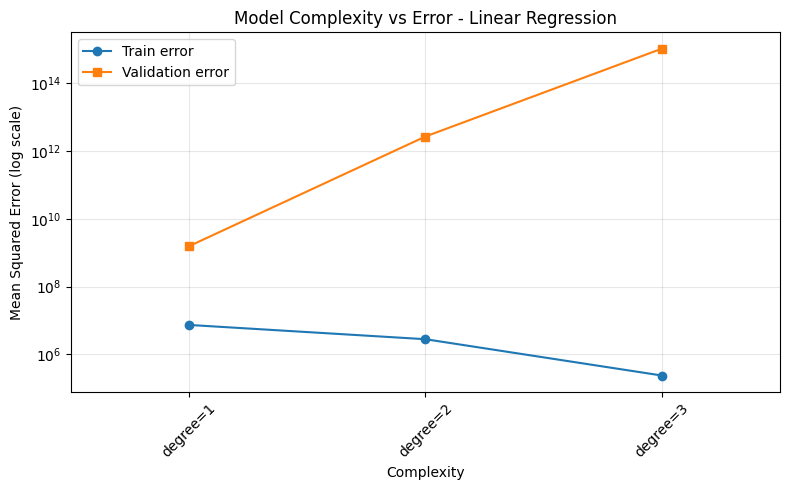

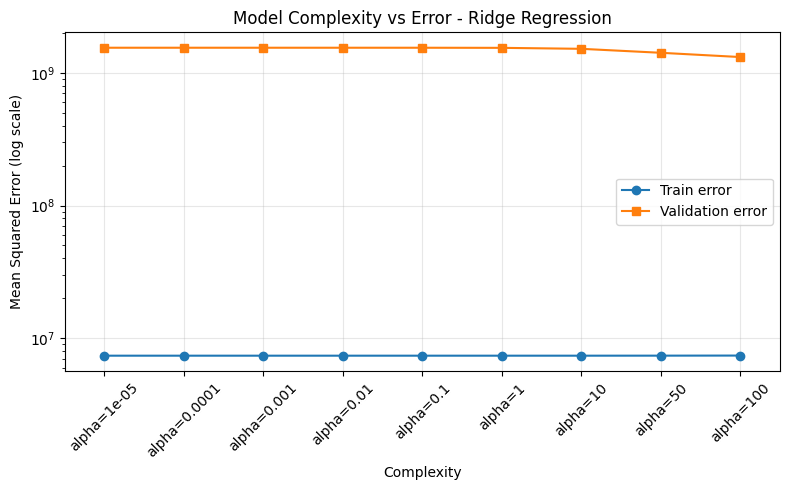

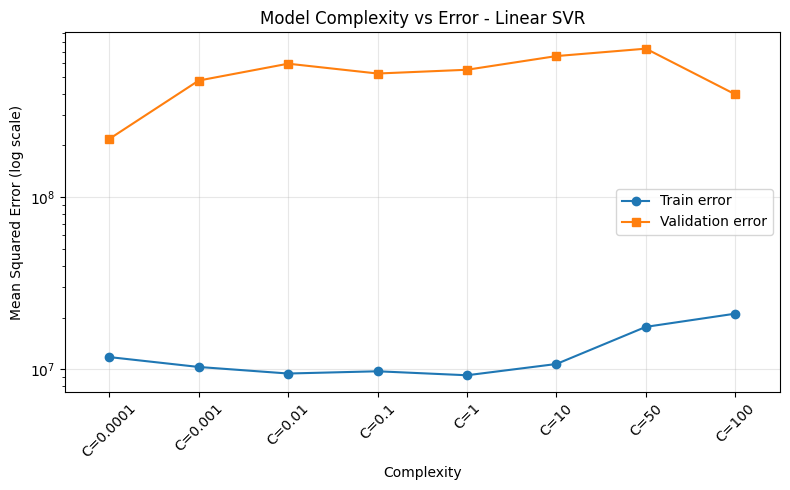

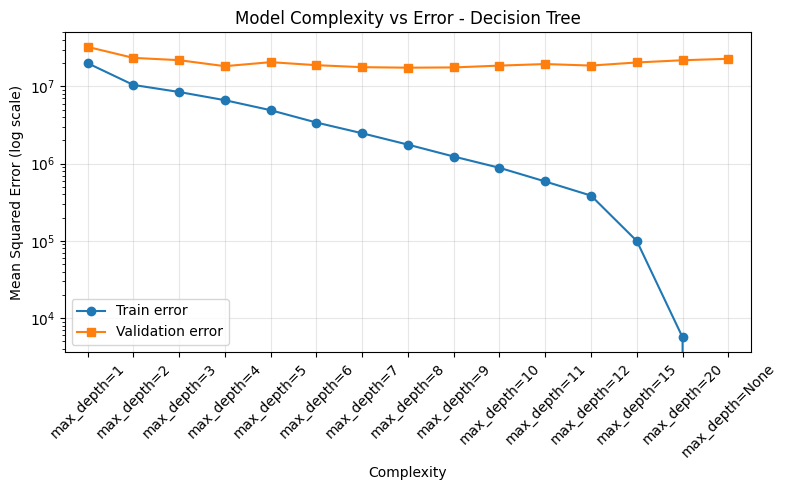

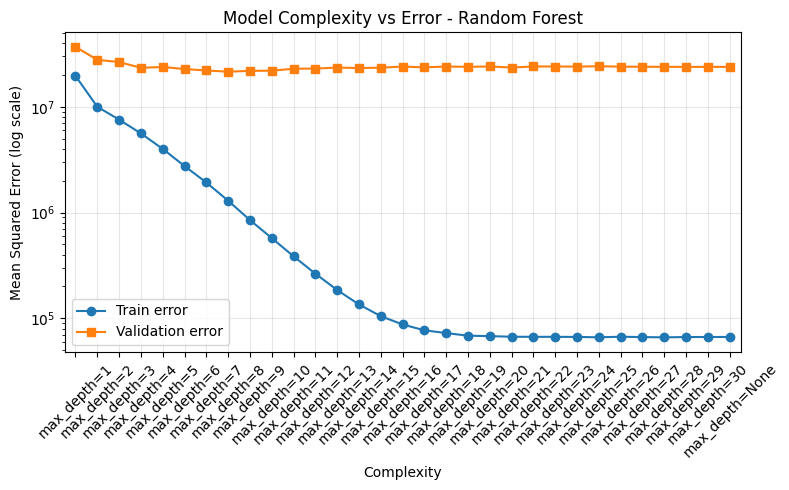

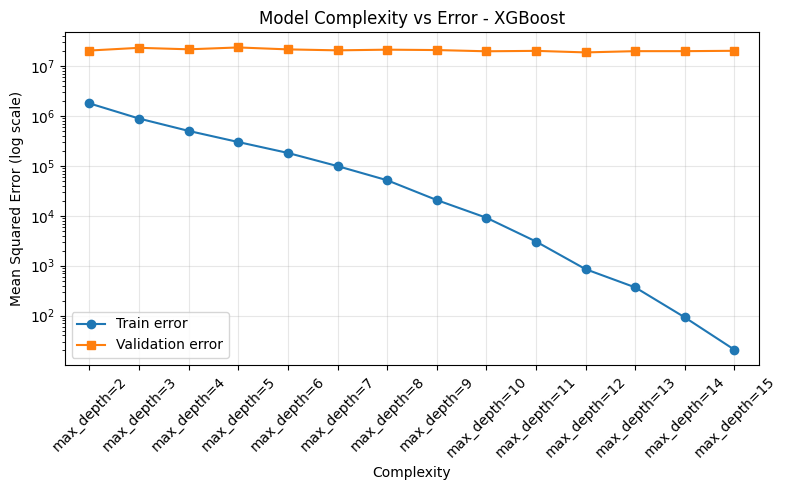


✓ ML models training complete!


In [ ]:
ml_model_configs = {
    "Linear Regression": {"degree": list(range(1, 4))},
    "Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 50, 100]},  
    "Linear SVR": {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]},  
    "Decision Tree": {"max_depth": list(range(1, 13)) + [15, 20, None]},  
    "Random Forest": {"max_depth": list(range(1, 31)) + [None]},  
    "XGBoost": {"max_depth": list(range(2, 16))}
}

ml_complexity_rows = []

for model_name, param_dict in ml_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for val in values:
            X_sub, y_sub = X_tr_sub_raw, y_tr_sub_raw
            X_val_sub_local, y_val_sub_local = X_val_sub_raw, y_val_sub_raw
            
            if model_name == "Decision Tree":
                model = DecisionTreeRegressor(max_depth=val, random_state=42)

            elif model_name == "Random Forest":
                model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42)

            elif model_name == "XGBoost":
                model = XGBRegressor(
                    max_depth=val,
                    n_estimators=50,
                    tree_method="hist",
                    random_state=42
                )

            elif model_name == "Linear Regression":
                # For polynomial features
                poly = PolynomialFeatures(degree=val, include_bias=False)
                X_sub_poly = poly.fit_transform(X_sub)
                X_val_sub_local_poly = poly.transform(X_val_sub_local)
                model = LinearRegression()
                model.fit(X_sub_poly, y_sub)
                train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                ml_complexity_rows.append({
                    "Model": model_name,
                    "Complexity": f"{param_name}={val}",
                    "Train error": train_err,
                    "Val error": val_err,
                    "Overfitting Index": train_err - val_err
                })
                continue  # Skip the regular fitting below
                
            elif model_name == "Ridge Regression":
                model = Ridge(alpha=val)
                
            elif model_name == "Linear SVR":
                model = LinearSVR(C=val, max_iter=5000)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            # Calculate errors
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            # Store
            ml_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

# Create ML results table
ml_cm_df = pd.DataFrame(ml_complexity_rows)
ml_cm_df["Complexity Level"] = ml_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("ML MODELS - Result Table 4 (Complexity vs Error):")
print("="*80)
display(ml_cm_df)

# Plot ML results
print("\nGenerating plots for ML models...")
for model in ml_cm_df["Model"].unique():
    temp = ml_cm_df[ml_cm_df["Model"] == model]
    plt.figure(figsize=(8,5))
    plt.plot(temp["Complexity Level"], temp["Train error"], marker='o', linestyle='-', label='Train error')
    plt.plot(temp["Complexity Level"], temp["Val error"], marker='s', linestyle='-', label='Validation error')
    plt.xticks(temp["Complexity Level"], temp["Complexity"], rotation=45)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.yscale('log')
    plt.title(f"Model Complexity vs Error - {model}")
    plt.xlabel("Complexity")
    plt.ylabel("Mean Squared Error (log scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✓ ML models training complete!")



TRAINING NEURAL NETWORK MODELS (SLOW)
⚠️  This section will take longer. Run when you're ready to wait.

Training MLP...
  Progress: 1/13 - hidden_units=8
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
  Progress: 2/13 - hidden_units=24
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
  Progress: 3/13 - hidden_units=40
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
  Progress: 4/13 - hidden_units=56
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
  Progress: 5/13 - hidden_units=72
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
  Progress: 6/13 - hidden_units=88
329/329 ━━━━━━━━━━━━━━━━

,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,MLP,hidden_units=8,0.009019,0.251985,-0.242967,1
1,MLP,hidden_units=24,0.006621,0.109563,-0.102943,2
2,MLP,hidden_units=40,0.005292,0.232234,-0.226941,3
3,MLP,hidden_units=56,0.004061,0.147095,-0.143033,4
4,MLP,hidden_units=72,0.004325,0.182733,-0.178408,5
5,MLP,hidden_units=88,0.003633,0.165418,-0.161785,6
6,MLP,hidden_units=104,0.003662,0.260990,-0.257328,7
7,MLP,hidden_units=120,0.003790,0.087047,-0.083257,8
8,MLP,hidden_units=136,0.003889,0.234317,-0.230427,9
9,MLP,hidden_units=152,0.002822,0.218274,-0.215452,10



Generating plots for Neural Network models...


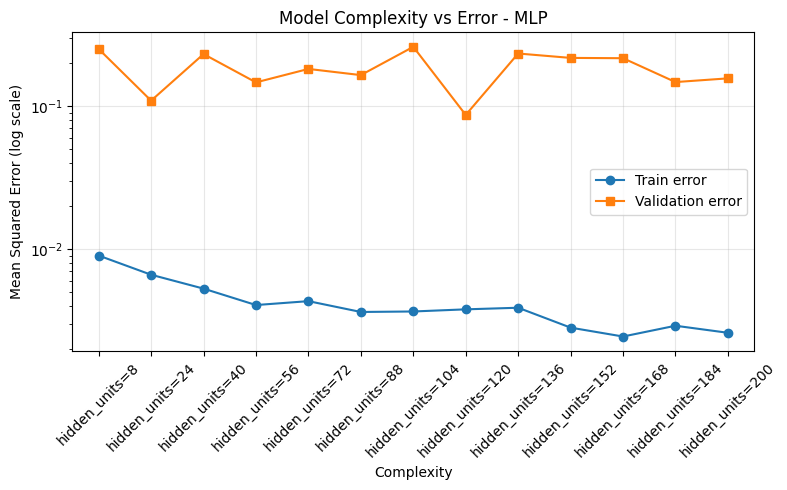

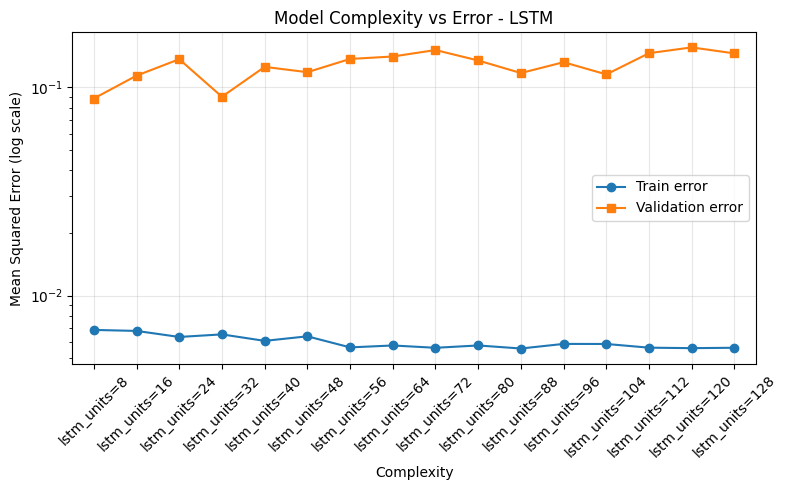

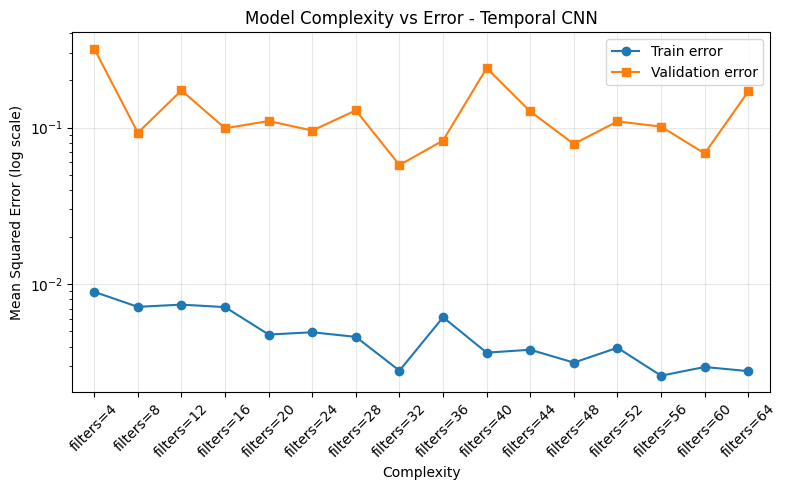


✓ Neural Network models training complete!

COMBINED RESULTS

Combined Result Table 4 - All Models Complexity vs Error:


,Model,Complexity,Train error,Val error,Overfitting Index,Complexity Level
0,Linear Regression,degree=1,7.383181e+06,1.546978e+09,-1.539595e+09,1
1,Linear Regression,degree=2,2.801680e+06,2.651242e+12,-2.651240e+12,2
2,Linear Regression,degree=3,2.383107e+05,1.029812e+15,-1.029812e+15,3
3,Ridge Regression,alpha=1e-05,7.383181e+06,1.546978e+09,-1.539595e+09,1
4,Ridge Regression,alpha=0.0001,7.383181e+06,1.546978e+09,-1.539595e+09,2
...,...,...,...,...,...,...
120,Temporal CNN,filters=48,3.165215e-03,7.858309e-02,-7.541787e-02,12
121,Temporal CNN,filters=52,3.935809e-03,1.094130e-01,-1.054772e-01,13
122,Temporal CNN,filters=56,2.612042e-03,1.014019e-01,-9.878987e-02,14
123,Temporal CNN,filters=60,2.967350e-03,6.830688e-02,-6.533953e-02,15



✓ All training complete!


In [ ]:
# ============================================================================
# SECTION 2: NEURAL NETWORK MODELS (Slow - Run this separately when ready)
# ============================================================================
print("\n" + "="*80)
print("TRAINING NEURAL NETWORK MODELS (SLOW)")
print("="*80)
print("⚠️  This section will take longer. Run when you're ready to wait.")
print("="*80)

nn_model_configs = {
    "MLP": {"hidden_units": list(range(8, 201, 16))},  
    "LSTM": {"lstm_units": list(range(8, 129, 8))},  
    "Temporal CNN": {"filters": list(range(4, 65, 4))}
}

nn_complexity_rows = []

for model_name, param_dict in nn_model_configs.items():
    print(f"\nTraining {model_name}...")
    for param_name, values in param_dict.items():
        for i, val in enumerate(values, 1):
            print(f"  Progress: {i}/{len(values)} - {param_name}={val}")
            
            X_sub, y_sub = X_tr_sub_scaled, y_tr_sub_scaled
            X_val_sub_local, y_val_sub_local = X_val_sub_scaled, y_val_sub_scaled
            
            if model_name == "MLP":
                model = MLP_Wrapper(hidden_units=val, epochs=10)
            elif model_name == "LSTM":
                model = LSTM_Wrapper(units=val, epochs=10)
            elif model_name == "Temporal CNN":
                model = TemporalCNN_Wrapper(filters=val, epochs=10)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            # Calculate errors
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            # Store
            nn_complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

# Create NN results table
nn_cm_df = pd.DataFrame(nn_complexity_rows)
nn_cm_df["Complexity Level"] = nn_cm_df.groupby("Model").cumcount() + 1

print("\n" + "="*80)
print("NEURAL NETWORK MODELS - Result Table 4 (Complexity vs Error):")
print("="*80)
display(nn_cm_df)

# Plot NN results
print("\nGenerating plots for Neural Network models...")
for model in nn_cm_df["Model"].unique():
    temp = nn_cm_df[nn_cm_df["Model"] == model]
    plt.figure(figsize=(8,5))
    plt.plot(temp["Complexity Level"], temp["Train error"], marker='o', linestyle='-', label='Train error')
    plt.plot(temp["Complexity Level"], temp["Val error"], marker='s', linestyle='-', label='Validation error')
    plt.xticks(temp["Complexity Level"], temp["Complexity"], rotation=45)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.yscale('log')
    plt.title(f"Model Complexity vs Error - {model}")
    plt.xlabel("Complexity")
    plt.ylabel("Mean Squared Error (log scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✓ Neural Network models training complete!")

# ============================================================================
# SECTION 3: COMBINE RESULTS (Run after both sections complete)
# ============================================================================
print("\n" + "="*80)
print("COMBINED RESULTS")
print("="*80)

# Combine all results
all_complexity_rows = ml_complexity_rows + nn_complexity_rows
combined_cm_df = pd.DataFrame(all_complexity_rows)
combined_cm_df["Complexity Level"] = combined_cm_df.groupby("Model").cumcount() + 1

print("\nCombined Result Table 4 - All Models Complexity vs Error:")
display(combined_cm_df)

print("\n✓ All training complete!")


Result Table 4 - Model-Complexity vs Error:


,Model,Complexity,Train error,Val error,Overfitting Index
0,Linear Regression,degree=1,7.383181e+06,1.546978e+09,-1.539595e+09
1,Linear Regression,degree=2,2.801680e+06,2.651242e+12,-2.651240e+12
2,Linear Regression,degree=3,2.383107e+05,1.029812e+15,-1.029812e+15


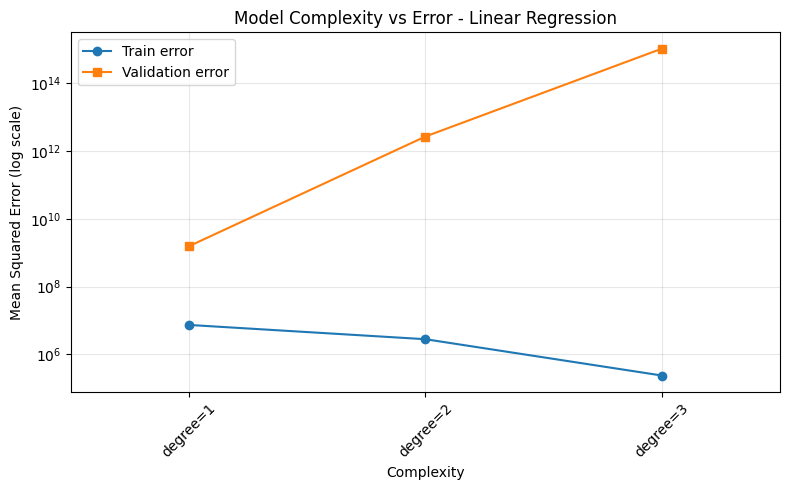

In [ ]:
# Model complexity vs Error

subsample_ratio = 0.3
N = int(len(X_train) * subsample_ratio)

# Non-NN models use raw data
X_tr_sub_raw  = X_train[:N].copy()
y_tr_sub_raw  = y_train[:N].copy()

X_val_sub_raw = X_train[N:].copy()
y_val_sub_raw = y_train[N:].copy()

# Neural nets use scaled data
X_tr_sub_scaled  = X_train_min_scaled[:N].copy()
y_tr_sub_scaled  = y_train_min_scaled[:N].copy()

X_val_sub_scaled = X_train_min_scaled[N:].copy()
y_val_sub_scaled = y_train_min_scaled[N:].copy()

diag_rows = []
complexity_rows = []

# define models to check for diagnostics
diag_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, tree_method="hist", random_state=42),
    "MLP": MLP_Wrapper(epochs=10),
    "LSTM": LSTM_Wrapper(epochs=10),
    "Temporal CNN": TemporalCNN_Wrapper(epochs=10)
}

# for name, mod in diag_models.items():
#     if name in ["MLP", "LSTM", "Temporal CNN"]:
#         d = bias_variance_diagnostics(mod,
#                                       X_tr_sub_scaled, y_tr_sub_scaled,
#                                       X_val_sub_scaled, y_val_sub_scaled)
#     else:
#         d = bias_variance_diagnostics(mod,
#                                       X_tr_sub_raw, y_tr_sub_raw,
#                                       X_val_sub_raw, y_val_sub_raw)

#     d_row = {"Model": name}
#     d_row.update(d)
#     diag_rows.append(d_row)

# result_table_3 = pd.DataFrame(diag_rows)
# print("Result Table 3 - Bias-Variance Diagnostics:")
# display(result_table_3)

# Model-Complexity vs Error
model_configs = {
    "Linear Regression": {"degree": list(range(1, 4))}
    # "Ridge Regression": {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] + list(range(10, 101, 10)) + list(range(200, 1001, 200))},  
    # "Linear SVR": {"C": [0.0001, 0.001, 0.01, 0.1, 1] + list(range(10, 101, 10)) + list(range(200, 1001, 200))},  
    # "Decision Tree": {"max_depth": list(range(1, 13)) + [15, 20, None]},  
    # "Random Forest": {"max_depth": list(range(1, 31)) + [None]},  
    # "XGBoost": {"max_depth": list(range(2, 16))},  
    # "MLP": {"hidden_units": list(range(8, 201, 16))},  
    # "LSTM": {"lstm_units": list(range(8, 129, 8))},  
    # "Temporal CNN": {"filters": list(range(4, 65, 4))}
}

def complexity_str(model_name,value_name,value):
    return f"{value_name}={value}"

from sklearn.preprocessing import PolynomialFeatures

for model_name, param_dict in model_configs.items():
    for param_name, values in param_dict.items():
        for val in values:
            #neuralnet
            if model_name in ["MLP","LSTM","Temporal CNN"]:
                X_sub,y_sub=X_tr_sub_scaled,y_tr_sub_scaled
                X_val_sub_local,y_val_sub_local=X_val_sub_scaled,y_val_sub_scaled
                if model_name=="MLP":
                    model=MLP_Wrapper(hidden_units=val, epochs=10)
                elif model_name=="LSTM":
                    model=LSTM_Wrapper(units=val,epochs=10)
                elif model_name=="Temporal CNN":
                    model=TemporalCNN_Wrapper(filters=val,epochs=10)
            
            #ml
            else:
                X_sub,y_sub=X_tr_sub_raw,y_tr_sub_raw
                X_val_sub_local,y_val_sub_local=X_val_sub_raw,y_val_sub_raw
                if model_name == "Decision Tree":
                    model = DecisionTreeRegressor(max_depth=val, random_state=42)

                elif model_name == "Random Forest":
                    model = RandomForestRegressor(max_depth=val, n_estimators=50, random_state=42)

                elif model_name == "XGBoost":
                    model = XGBRegressor(
                        max_depth=val,
                        n_estimators=50,
                        tree_method="hist",
                        random_state=42
                    )

                elif model_name == "Linear Regression":
                    # For polynomial features
                    poly = PolynomialFeatures(degree=val, include_bias=False)
                    X_sub_poly = poly.fit_transform(X_sub)
                    X_val_sub_local_poly = poly.transform(X_val_sub_local)
                    model = LinearRegression()
                    model.fit(X_sub_poly, y_sub)
                    train_err = mean_squared_error(y_sub, model.predict(X_sub_poly))
                    val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local_poly))
                    complexity_rows.append({
                        "Model": model_name,
                        "Complexity": f"{param_name}={val}",
                        "Train error": train_err,
                        "Val error": val_err,
                        "Overfitting Index": train_err - val_err
                    })
                    continue  # Skip the regular fitting below
                    
                elif model_name == "Ridge Regression":
                    model = Ridge(alpha=val)
                    
                elif model_name == "Linear SVR":
                    model = LinearSVR(C=val, max_iter=5000)
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)
            
            # Calculate errors
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            # Store
            complexity_rows.append({
                "Model": model_name,
                "Complexity": f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })

cm_df = pd.DataFrame(complexity_rows)
cm_df["Complexity Level"] = cm_df.groupby("Model").cumcount() + 1

result_table_4 = pd.DataFrame(complexity_rows)
print("Result Table 4 - Model-Complexity vs Error:")
display(result_table_4)

# ---------------------------------------------------
# Plot Graph with Log Scale
for model in cm_df["Model"].unique():
    temp = cm_df[cm_df["Model"] == model]
    plt.figure(figsize=(8,5))
    plt.plot(temp["Complexity Level"], temp["Train error"], marker='o', linestyle='-', label='Train error')
    plt.plot(temp["Complexity Level"], temp["Val error"], marker='s', linestyle='-', label='Validation error')
    plt.xticks(temp["Complexity Level"], temp["Complexity"], rotation=45)
    plt.xlim(0.5, temp["Complexity Level"].max() + 0.5)
    plt.yscale('log')  # Added log scale to make both lines visible
    plt.title(f"Model Complexity vs Error - {model}")
    plt.xlabel("Complexity")
    plt.ylabel("Mean Squared Error (log scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



# # Regularization Impact (Ridge Regression) - vary alpha and report train/val/test R2 + coef magnitude
# alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
# ridge_rows = []
# for a in alphas:
#     r = Ridge(alpha=a)
#     r.fit(X_train, y_train) # Ridge will always use the original (unscaled) X_train, y_train
#     train_r2 = r2_score(y_train, r.predict(X_train))

#     # Recalculate X_val_sub_raw for consistency with non-NN models in bias-variance diagnostics
#     _, X_val_sub_raw, _, y_val_sub_raw = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#     val_r2 = r2_score(y_val_sub_raw, r.predict(X_val_sub_raw))
#     test_r2 = r2_score(y_test, r.predict(X_test))
#     coef_mag = np.mean(np.abs(r.coef_)) if hasattr(r, 'coef_') else None
#     ridge_rows.append({"Alpha": a, "Train R²": train_r2, "Val R²": val_r2, "Test R²": test_r2, "Coefficient Magnitude": coef_mag})

# result_table_5 = pd.DataFrame(ridge_rows)
# print("Result Table 5 - Ridge Regularization Impact:")
# display(result_table_5)

In [ ]:
# error analysis

In [ ]:
# feature importance

## D. 5-fold cv

In [ ]:
# Part A - Step 4: 5-fold cross validation table
def cross_val_summary(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []
    for train_idx, val_idx in kf.split(X):
        Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yv = y.iloc[train_idx], y.iloc[val_idx]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr, ytr)
        preds = model.predict(Xv)
        r2_scores.append(r2_score(yv, preds))
        mse_scores.append(mean_squared_error(yv, preds))
    return {"Mean R2": np.mean(r2_scores), "Std R2": np.std(r2_scores),
            "Mean MSE": np.mean(mse_scores), "Std MSE": np.std(mse_scores)}

cv_models = {
    "Linear Regression": LinearRegression(),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1,
                            tree_method=XGBOOST_TREE_METHOD if XGBOOST_TREE_METHOD != 'auto' else 'hist')
}

cv_rows = []
for name, mod in cv_models.items():
    summary = cross_val_summary(mod, X_train, y_train, folds=5)
    row = {"Model": name}
    row.update(summary)
    cv_rows.append(row)

result_table_6 = pd.DataFrame(cv_rows)
print("Result Table 6 - 5-fold Cross Validation Summary:")
display(result_table_6)


## Select winner models

In [ ]:
df_table1 = result_table_1.copy()
# Quick pick via lowest RMSE per category (simple heuristics):
# Regression models: Linear Regression, Linear SVR, Ridge Regression
regression_rows = df_table1[df_table1['Model'].isin(['Linear Regression','SVR','Ridge Regression'])]
winner_regression = regression_rows.sort_values('RMSE').iloc[0]['Model'] if not regression_rows.empty else None

tree_rows = df_table1[df_table1['Model'].isin(['Decision Tree','Random Forest','XGBoost'])]
winner_tree = tree_rows.sort_values('RMSE').iloc[0]['Model'] if not tree_rows.empty else None

neural_rows = df_table1[df_table1['Model'].isin(['MLP','LSTM','Temporal CNN'])]
winner_neural = neural_rows.sort_values('RMSE').iloc[0]['Model'] if not neural_rows.empty else None

print("Winner candidates (simple RMSE heuristic):")
print("Regression winner:", winner_regression)
print("Tree-based winner:", winner_tree)
print("Neural winner:", winner_neural)


# Part B

## Comprehensive preprocessing

In [ ]:
# ============================================
# PART B — Feature Engineering with SVR / RF / LSTM 
# ============================================

import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

results_partB = []

# Baseline reference from Part A Step 2 (unchanged)
X_train_base = X_train_min.copy().reset_index(drop=True)
X_test_base  = X_test_min.copy().reset_index(drop=True)
y_train_base = pd.Series(y_train_min).reset_index(drop=True)
y_test_base  = pd.Series(y_test_min).reset_index(drop=True)

# global scaler_y assumed to be fitted on Part A original y_train_min
# If not, ensure scaler_y = MinMaxScaler().fit(y_train_base.values.reshape(-1,1))

# Create default Part B baseline scaler (fit on baseline X_train)
scaler_X_partB = MinMaxScaler().fit(X_train_base)


# -----------------------------
# SAFE feature functions
# -----------------------------

def add_lag_safe(df, target_series, lags=[24], fill_value=None):
    """
    Add lag features using shift. To preserve row count and avoid leakage, fill NaNs
    with fill_value (e.g. training target mean). `df` is a DataFrame of features;
    `target_series` is the corresponding target Series (same index).
    Returns a new DataFrame (copy) with lag columns added.
    """
    df_new = df.copy().reset_index(drop=True)
    tgt = pd.Series(target_series).reset_index(drop=True)
    if fill_value is None:
        fill_value = float(tgt.mean())
    for lag in lags:
        col_name = f"lag_{lag}"
        df_new[col_name] = tgt.shift(lag).fillna(fill_value).values
    return df_new


def add_rolling_safe(df, target_series, window=24):
    """
    Add rolling mean/std computed with min_periods=1 (uses past available values only).
    Keeps same row count.
    """
    df_new = df.copy().reset_index(drop=True)
    tgt = pd.Series(target_series).reset_index(drop=True)
    df_new[f"roll_mean_{window}"] = tgt.rolling(window=window, min_periods=1).mean().values
    df_new[f"roll_std_{window}"] = tgt.rolling(window=window, min_periods=1).std().fillna(0).values
    return df_new


def add_cyclical_safe(df, hour_col="hour"):
    df_new = df.copy().reset_index(drop=True)
    if hour_col not in df_new.columns:
        raise ValueError(f"{hour_col} not in dataframe columns")
    df_new["hour_sin"] = np.sin(2 * np.pi * df_new[hour_col] / 24)
    df_new["hour_cos"] = np.cos(2 * np.pi * df_new[hour_col] / 24)
    return df_new


def add_weather_interactions_safe(df, weather_cols):
    df_new = df.copy().reset_index(drop=True)
    for i, a in enumerate(weather_cols):
        for b in weather_cols[i+1:]:
            if a in df_new.columns and b in df_new.columns:
                df_new[f"{a}_x_{b}"] = df_new[a] * df_new[b]
    return df_new


# -----------------------------
# train_three_models (cleaned)
# -----------------------------
def train_three_models(X_train_scaled, X_test_scaled, 
                       y_train_scaled, y_test_scaled,
                       X_train_orig, X_test_orig,
                       y_train_orig, y_test_orig,
                       scaler_y):
    """
    Train SVR (LinearSVR), RandomForest, and LSTM (fast) using the provided datasets.
    - X_train_scaled/X_test_scaled: numpy arrays for sequence models (LSTM)
    - X_train_orig/X_test_orig: DataFrame/array used for SVR/RF training (unscaled originals expected)
    - y_train_scaled/y_test_scaled: scaled y arrays for LSTM training (shape (n,1))
    - y_train_orig/y_test_orig: original y Series for SVR/RF evaluation/metrics
    - scaler_y: fitted scaler to inverse-transform LSTM outputs
    Returns results_list (dicts)
    """
    results_list = []

    # -------------------------
    # 1) SVR (LinearSVR)
    # -------------------------
    print("Training SVR...")
    svr = LinearSVR(max_iter=2000, random_state=42)

    t0 = time.time()
    svr.fit(X_train_orig, y_train_orig)
    t_train = time.time() - t0

    t0 = time.time()
    y_pred_svr = svr.predict(X_test_orig)
    t_inf = (time.time() - t0) / max(1, len(X_test_orig))

    m = compute_metrics(y_test_orig.values.ravel(), y_pred_svr)
    m.update({"Training Time (s)": t_train, "Inference Time per Sample (s)": t_inf, "Model Size (MB)": np.nan})
    m["Model"] = "LinearSVR"
    results_list.append(m)

    # -------------------------
    # 2) Random Forest
    # -------------------------
    print("Training Random Forest...")
    rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

    t0 = time.time()
    rf.fit(X_train_orig, y_train_orig)
    t_train = time.time() - t0

    t0 = time.time()
    y_pred_rf = rf.predict(X_test_orig)
    t_inf = (time.time() - t0) / max(1, len(X_test_orig))

    m = compute_metrics(y_test_orig.values.ravel(), y_pred_rf)
    m.update({"Training Time (s)": t_train, "Inference Time per Sample (s)": t_inf, "Model Size (MB)": np.nan})
    m["Model"] = "RandomForest"
    results_list.append(m)

    # -------------------------
    # 3) LSTM (fast)
    # -------------------------
    print("Training LSTM (fast)...")
    # Expect X_train_scaled/X_test_scaled to be numpy arrays shaped (n_samples, timesteps, features)
    X_tr = np.asarray(X_train_scaled)
    X_te = np.asarray(X_test_scaled)
    y_tr = np.asarray(y_train_scaled).reshape(-1, 1)
    y_te = np.asarray(y_test_scaled).reshape(-1, 1)

    # If these are 2D (not sequence), create sequences with default timesteps=24
    timesteps = 24
    # create_sequences should return arrays trimmed so y aligns with sequences
    X_tr_seq, y_tr_seq = create_sequences(X_tr, y_tr.flatten(), timesteps)
    X_te_seq, y_te_seq = create_sequences(X_te, y_te.flatten(), timesteps)

    # Build LSTM object (assumes LSTM_Model wrapper exposes .model Keras model)
    lstm = LSTM_Model(input_shape=(X_tr_seq.shape[1], X_tr_seq.shape[2]),
                     units=30, epochs=15, batch_size=32)

    t0 = time.time()
    lstm.model.fit(X_tr_seq, y_tr_seq, epochs=15, batch_size=32, verbose=0)
    t_train = time.time() - t0

    t0 = time.time()
    y_pred_scaled = lstm.model.predict(X_te_seq, verbose=0)
    t_inf = (time.time() - t0) / max(1, len(X_te_seq))

    # inverse transform predictions and true y (note scaler_y expects shape (n,1))
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_te_seq.reshape(-1, 1)).flatten()

    m = compute_metrics(y_true, y_pred)
    m.update({"Training Time (s)": t_train, "Inference Time per Sample (s)": t_inf, "Model Size (MB)": np.nan})
    m["Model"] = "LSTM"
    results_list.append(m)

    return results_list


# -----------------------------
# run_step (cleaned & safe)
# -----------------------------
def run_step(step_num, action_name, X_train_step, X_test_step, 
             y_train_step=None, y_test_step=None, scaler_override=None):
    """
    Run a single preprocessing step -> train models -> collect results.
    Important safety rules:
    - Do NOT drop rows (we preserve original train/test lengths)
    - Lag NaNs are filled with training target mean to avoid leakage
    - Rolling uses min_periods=1 (past-only)
    - scaler_override: a fitted scaler object (fit on X_train_step) or None
    Returns X_train_step, X_test_step, y_train_step, y_test_step (unchanged row counts)
    """
    # default to base if not provided
    if y_train_step is None:
        y_train_step = y_train_base
        y_test_step = y_test_base

    # Ensure inputs are DataFrames/Series and reset_index to keep alignment
    X_train_step = pd.DataFrame(X_train_step).reset_index(drop=True)
    X_test_step  = pd.DataFrame(X_test_step).reset_index(drop=True)
    y_train_step = pd.Series(y_train_step).reset_index(drop=True)
    y_test_step  = pd.Series(y_test_step).reset_index(drop=True)

    # scaler for X: if override passed, use it, else fit new on X_train_step
    if scaler_override is not None:
        scaler_used = scaler_override
    else:
        scaler_used = MinMaxScaler().fit(X_train_step)

    # Scale X for sequence models (LSTM) — we will produce 2D arrays for create_sequences later
    X_train_scaled = scaler_used.transform(X_train_step)
    X_test_scaled  = scaler_used.transform(X_test_step)

    # Scale y using global scaler_y (assumed fitted on original training y)
    y_train_scaled = scaler_y.transform(y_train_step.values.reshape(-1, 1))
    y_test_scaled  = scaler_y.transform(y_test_step.values.reshape(-1, 1))

    print(f"\n========== STEP {step_num}: {action_name} ==========")

    # Train models (pass both scaled for LSTM and original for SVR/RF)
    res_list = train_three_models(
        X_train_scaled, X_test_scaled,
        y_train_scaled, y_test_scaled,
        X_train_step.values, X_test_step.values,
        y_train_step, y_test_step,
        scaler_y
    )

    # Pack results into results_partB in consistent columns
    row = {"step": step_num, "preprocessing action": action_name}
    for r in res_list:
        if r["Model"] == "LinearSVR":
            row["SVR R²"] = r["R2"]
        elif r["Model"] == "RandomForest":
            row["RF R²"] = r["R2"]
        elif r["Model"] == "LSTM":
            row["LSTM R²"] = r["R2"]

    results_partB.append(row)

    return X_train_step, X_test_step, y_train_step, y_test_step


# -----------------------------
# STEP 0 — Baseline (IQR clipped)
# -----------------------------
X_train_s0, X_test_s0, y_train_s0, y_test_s0 = run_step(
    0, "baseline",
    X_train_base, X_test_base,
    y_train_base, y_test_base,
    scaler_override=scaler_X_partB
)


# -----------------------------
# STEP 1 — Baseline + Lag Features (safe: fill NaNs with train mean)
# -----------------------------
# Add lag_24 using training target mean to fill top NaNs and preserve length
X_train_s1 = add_lag_safe(X_train_base, y_train_base, lags=[24], fill_value=float(y_train_base.mean()))
X_test_s1  = add_lag_safe(X_test_base, y_test_base, lags=[24], fill_value=float(y_train_base.mean()))

# Select feature columns (append new lag column)
X_train_s1 = X_train_s1[feature_cols + ["lag_24"]]
X_test_s1  = X_test_s1[feature_cols + ["lag_24"]]
y_train_s1 = y_train_base
y_test_s1  = y_test_base

scaler_X_s1 = MinMaxScaler().fit(X_train_s1)

X_train_s1, X_test_s1, y_train_s1, y_test_s1 = run_step(
    1, "baseline + lag_24",
    X_train_s1, X_test_s1,
    y_train_s1, y_test_s1,
    scaler_override=scaler_X_s1
)


# -----------------------------
# STEP 2 — Step1 + Rolling Stats (safe: min_periods=1)
# -----------------------------
# Build rolling features on top of original target, but preserve length
X_train_s2 = add_rolling_safe(X_train_s1, y_train_base, window=24)
X_test_s2  = add_rolling_safe(X_test_s1, y_test_base, window=24)

# keep the same feature list + new rolling cols
X_train_s2 = X_train_s2[feature_cols + ["lag_24", "roll_mean_24", "roll_std_24"]]
X_test_s2  = X_test_s2[feature_cols + ["lag_24", "roll_mean_24", "roll_std_24"]]
y_train_s2 = y_train_base
y_test_s2  = y_test_base

scaler_X_s2 = MinMaxScaler().fit(X_train_s2)

X_train_s2, X_test_s2, y_train_s2, y_test_s2 = run_step(
    2, "step1 + rolling statistics",
    X_train_s2, X_test_s2,
    y_train_s2, y_test_s2,
    scaler_override=scaler_X_s2
)


# -----------------------------
# STEP 3 — Step2 + Cyclical Encoding
# -----------------------------
X_train_s3 = add_cyclical_safe(X_train_s2, hour_col="hour")
X_test_s3  = add_cyclical_safe(X_test_s2, hour_col="hour")

X_train_s3 = X_train_s3[feature_cols + ["lag_24", "roll_mean_24", "roll_std_24", "hour_sin", "hour_cos"]]
X_test_s3  = X_test_s3[feature_cols + ["lag_24", "roll_mean_24", "roll_std_24", "hour_sin", "hour_cos"]]
y_train_s3 = y_train_base
y_test_s3  = y_test_base

scaler_X_s3 = MinMaxScaler().fit(X_train_s3)

X_train_s3, X_test_s3, y_train_s3, y_test_s3 = run_step(
    3, "step2 + cyclical encoding",
    X_train_s3, X_test_s3,
    y_train_s3, y_test_s3,
    scaler_override=scaler_X_s3
)


# -----------------------------
# STEP 4 — Step3 + Weather Interactions
# -----------------------------
X_train_s4 = add_weather_interactions_safe(X_train_s3, weather_features)
X_test_s4  = add_weather_interactions_safe(X_test_s3, weather_features)

# ensure we keep consistent feature columns (add any new interaction columns automatically)
cols_s4 = list(X_train_s4.columns)
X_train_s4 = X_train_s4[cols_s4]
X_test_s4  = X_test_s4[cols_s4]

y_train_s4 = y_train_base   # use y from baseline (preserved)
y_test_s4  = y_test_base

scaler_X_s4 = MinMaxScaler().fit(X_train_s4)

X_train_s4, X_test_s4, y_train_s4, y_test_s4 = run_step(
    4, "step3 + weather interactions",
    X_train_s4, X_test_s4,
    y_train_s4, y_test_s4,
    scaler_override=scaler_X_s4
)


# -----------------------------
# Final Results Table with Delta Analysis
# -----------------------------
df_partB = pd.DataFrame(results_partB)

# Fill missing R2 columns with NaN when a model failed to run in a step
for col in ["SVR R²", "RF R²", "LSTM R²"]:
    if col not in df_partB.columns:
        df_partB[col] = np.nan

# Baseline values
baseline_svr = df_partB.loc[df_partB["step"] == 0, "SVR R²"].values[0]
baseline_rf = df_partB.loc[df_partB["step"] == 0, "RF R²"].values[0]
baseline_lstm = df_partB.loc[df_partB["step"] == 0, "LSTM R²"].values[0]

df_partB["SVR Δ"] = df_partB["SVR R²"] - baseline_svr
df_partB["RF Δ"] = df_partB["RF R²"] - baseline_rf
df_partB["LSTM Δ"] = df_partB["LSTM R²"] - baseline_lstm
df_partB["bestΔ"] = df_partB[["SVR Δ", "RF Δ", "LSTM Δ"]].max(axis=1)

print("\n" + "="*80)
print("PART B RESULTS - CUMULATIVE FEATURE ENGINEERING (FIXED)")
print("="*80)
display(df_partB)

# Best step indices
best_svr_step = int(df_partB.loc[df_partB["SVR R²"].idxmax(), "step"])
best_rf_step = int(df_partB.loc[df_partB["RF R²"].idxmax(), "step"])
best_lstm_step = int(df_partB.loc[df_partB["LSTM R²"].idxmax(), "step"])

print("\nBEST STEPS FOR HYPERPARAMETER TUNING")
print("="*80)
print(f"SVR best at Step {best_svr_step}: {df_partB.loc[df_partB['step']==best_svr_step, 'preprocessing action'].values[0]}")
print(f"RF best at Step {best_rf_step}: {df_partB.loc[df_partB['step']==best_rf_step, 'preprocessing action'].values[0]}")
print(f"LSTM best at Step {best_lstm_step}: {df_partB.loc[df_partB['step']==best_lstm_step, 'preprocessing action'].values[0]}")

# Store best datasets for hyperparameter tuning (these keep original row counts)
best_datasets = {
    "SVR": {
        "step": best_svr_step,
        "X_train": eval(f"X_train_s{best_svr_step}"),
        "X_test": eval(f"X_test_s{best_svr_step}"),
        "y_train": eval(f"y_train_s{best_svr_step}"),
        "y_test": eval(f"y_test_s{best_svr_step}")
    },
    "RF": {
        "step": best_rf_step,
        "X_train": eval(f"X_train_s{best_rf_step}"),
        "X_test": eval(f"X_test_s{best_rf_step}"),
        "y_train": eval(f"y_train_s{best_rf_step}"),
        "y_test": eval(f"y_test_s{best_rf_step}")
    },
    "LSTM": {
        "step": best_lstm_step,
        "X_train": eval(f"X_train_s{best_lstm_step}"),
        "X_test": eval(f"X_test_s{best_lstm_step}"),
        "y_train": eval(f"y_train_s{best_lstm_step}"),
        "y_test": eval(f"y_test_s{best_lstm_step}")
    }
}

print("\nBest datasets stored in 'best_datasets' dictionary (row counts preserved)")
print("Ready for hyperparameter tuning!")


## Hyperparameter tuning

### Linear SVR

### RF

In [ ]:
# ============================================
# PART B — RandomForest Hyperparameter Tuning
# ============================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Utility: evaluate RF model on train/val/test
def eval_rf_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """Fit model, evaluate on train/val/test, and return metrics dict."""
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    m_train = compute_metrics(y_train, pred_train)
    m_val   = compute_metrics(y_val, pred_val)
    m_test  = compute_metrics(y_test, pred_test)

    return {
        "Train_R2": m_train["R2"],
        "Val_R2": m_val["R2"],
        "Test_R2": m_test["R2"],
        "MAE": m_test["MAE"],
        "RMSE": m_test["RMSE"],
    }


# ============================
# Load the best RF dataset
# ============================
rf_data = best_datasets["RF"]
X_train_full = rf_data["X_train"]
X_test_full  = rf_data["X_test"]
y_train_full = rf_data["y_train"]
y_test_full  = rf_data["y_test"]

# Create train/val split (keep test untouched)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=False
)

print("RF Tuning using Step:", rf_data["step"])
print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test_full.shape)


# ============================================
# Define experiment grid
# ============================================

experiment_grid = [
    # Small fast sweeps
    {"n_estimators": 100, "max_depth": 10,  "min_samples_split": 2,  "max_features": "sqrt"},
    {"n_estimators": 100, "max_depth": 20,  "min_samples_split": 5,  "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": 20,  "min_samples_split": 2,  "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": None, "min_samples_split": 2, "max_features": "sqrt"},

    # Larger models
    {"n_estimators": 300, "max_depth": 20,  "min_samples_split": 2,  "max_features": "log2"},
    {"n_estimators": 300, "max_depth": None, "min_samples_split": 5, "max_features": "log2"},
    {"n_estimators": 500, "max_depth": None, "min_samples_split": 2, "max_features": 0.8},
]


# ============================================
# Run experiments
# ============================================

results_rf_tuning = []

for params in experiment_grid:
    # create model
    model = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"],
        max_features=params["max_features"],
        random_state=42,
        n_jobs=-1,
    )

    # train & eval
    metrics = eval_rf_model(
        model,
        X_train, X_val, X_test_full,
        y_train, y_val, y_test_full
    )

    # record row
    row = {
        "n_estimators": params["n_estimators"],
        "max_depth": params["max_depth"],
        "min_samples_split": params["min_samples_split"],
        "max_features": params["max_features"],
        "Train R²": metrics["Train_R2"],
        "Val R²": metrics["Val_R2"],
        "Test R²": metrics["Test_R2"],
        "MAE": metrics["MAE"],
        "RMSE": metrics["RMSE"],
    }

    results_rf_tuning.append(row)

# to table
df_rf_tuning = pd.DataFrame(results_rf_tuning)
df_rf_tuning


### LSTM

## Ensemble Model